In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rn
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from sklearn.inspection import PartialDependenceDisplay
from sklearn import metrics
%matplotlib inline

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier, export_graphviz , plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics # Import scikit-learn metrics module for accuracy calculation
from sklearn import preprocessing # Import preprocessing for String-Int conversion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler


from sklearn.neural_network import MLPClassifier

from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.regularizers import l1_l2

from keras.callbacks import ModelCheckpoint

from pylorentz import Momentum4

import matplotlib
from sklearn import metrics
from scipy.spatial import distance

from atlasify import atlasify

2023-05-18 13:49:17.278566: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Defining useful functions

In [2]:
def plot_dscore(d_score,ax):
    bins = np.linspace(0,1,40)
    labels = ["non. res.","VBF"]
    for signal in [0,1]:
        mask = y_test == signal
        non_zero = np.count_nonzero(~np.isnan(d_score[mask]))
        weights = np.ones_like(d_score[mask])/float(non_zero)
        ax.hist(d_score[mask],alpha=0.5, label=labels[signal],bins = bins,weights=weights)
    ax.set_xlabel("Discriminant score")
    ax.set_ylabel("Fraction")
    ax.legend()
    #atlasify("work in progress")
    #plt.savefig("discriminant_distribution_VBF_vs_non_res(m_yy_less5%,pt_y1,pt_y2).pdf")
    #plt.show()

In [3]:
def plot_ROC(d_score,ax):
    effs=[]
    bins = np.linspace(0,1,50)
    back = d_score[y_test==0]
    sig = d_score[y_test==1]
    for dist in [back,sig]:
            # Normalise distributions
            non_zero = np.count_nonzero(~np.isnan(dist))
            weights = np.ones_like(dist)/float(non_zero)
            # Calculate signal and background efficiencies
            frac = np.histogram(dist,bins=bins,weights=weights)[0]
            eff = 1-np.append(0,np.cumsum(frac))
            effs.append(eff)
    # Plot ROC curve
    ax.plot(effs[0],effs[1])
    # Calculate AUC
    auc = metrics.auc(effs[0], effs[1])
    ax.text(x=0,y=0.85,s="AUC= "+"{:.4f}".format(round(auc, 4)))
    ax.plot([0,1], [0,1], linestyle='--', color='red')
    ax.set_xlabel("Background efficiency")
    ax.set_ylabel("Signal efficiency")
    ax.legend(["non res. bkg","VBF","Random classifier"])
    #atlasify("work in progress")
#plt.show()

In [4]:
def plot_D_score_myy(d_score,ax):
    non_res = np.histogram(myy_test[y_test==0],bins=np.linspace(105e3,160e3,80))
    bin_width = non_res[1][1]-non_res[1][0]
    bin_centres = np.linspace(non_res[1][0]+(bin_width/2),non_res[1][-1]-(bin_width/2),79)
    weighted_dist = np.histogram(myy_test[y_test==0],bins=np.linspace(105e3,160e3,80),weights=d_score[y_test==0])
    ax.hist(bin_centres,bins=non_res[1],weights=weighted_dist[0]/non_res[0])
    ax.set_title("D score values as a function of m_yy for non. res. bkg.")
    ax.set_xlabel("m_yy")
    ax.set_ylabel("D score")
    #atlasify("work in progress")
    #plt.savefig("D_score_as_function_of_m_yy_non_res(m_yy_less5%,pt_y1,pt_y2).pdf")
    #plt.show()

In [5]:
def plot_sculpting(d_score,cut,ax,y_scale):
    color1 = matplotlib.cm.get_cmap("Paired")(1/12)
    color2 = matplotlib.cm.get_cmap("Paired")(0/12)
    color3 = matplotlib.cm.get_cmap("Paired")(7/12)
    
    selection = (myy_test[y_test==0]>105e3)&(myy_test[y_test==0]<160e3)
    back = myy_test[y_test==0][selection]
    sig = myy_test[y_test==1]
    sig_cut = d_score[y_test==1][np.argsort(-d_score[y_test==1])][:int(d_score[y_test==1].shape[0]*cut)]
    d_cut = sig_cut[-1]
    back_cut = back[d_score[y_test==0][selection]>d_cut]
    bins=np.linspace(105e3,160e3,80)
    signal = [back,back_cut,sig]
    labels = ["non. res.", "non res. at {}% sig. eff.".format(int(cut*100)),"VBF"]
    hist = ["step","bar","step"]
    # color = ["tab:blue","tab:darkgreen","tab:orange"]
    color = [color1,color2,color3]
    for signal, values in enumerate(signal):
        non_zero = np.count_nonzero(~np.isnan(values))
        weights = np.ones_like(values)/float(non_zero)
        ax.hist(values,alpha=1, label=labels[signal],bins = bins,weights=weights,histtype=hist[signal],color=color[signal],
                linewidth=2)

    ax.set_title("normalised m_yy distributions")
    ax.set_xlabel("m_yy")
    ax.set_ylabel("fraction")
    ax.set_yscale(y_scale)
    ax.legend()
    #atlasify("work in progress")
#plt.savefig("m_yy_dist_D_0.5_non_res(m_yy_less5%).pdf")
#plt.show()

In [6]:
def accuracy(d_score, cut):
    selection = (myy_test[y_test==0]>105e3)&(myy_test[y_test==0]<160e3)
    back = myy_test[y_test==0][selection]
    sig = myy_test[y_test==1]
    sig_cut = d_score[y_test==1][np.argsort(-d_score[y_test==1])][:int(d_score[y_test==1].shape[0]*cut)]
    d_cut = sig_cut[-1]
    back_cut = back[d_score[y_test==0][selection]>d_cut]
    #print(d_cut)
    tp = d_score[d_score>d_cut][y_test[d_score>d_cut] == 1].size
    tn = d_score[d_score<d_cut][y_test[d_score<d_cut] == 0].size
    total = d_score.size
    accuracy = (tp + tn)/total
    return accuracy

In [7]:
def JSD(d_score,cut,region):
    selection = (myy_test[y_test==0]>105e3)&(myy_test[y_test==0]<160e3)
    back = myy_test[y_test==0][selection]
    sig = myy_test[y_test==1]
    sig_cut = d_score[y_test==1][np.argsort(-d_score[y_test==1])][:int(d_score[y_test==1].shape[0]*cut)]
    d_cut = sig_cut[-1]
    back_cut = back[d_score[y_test==0][selection]>d_cut]
    
    dists=[back,back_cut]
    fracs=[]
    bins = np.linspace(105e3,160e3,40)
    bin_width = bins[1]-bins[0]
    bin_centres = np.linspace(bins[0]+(bin_width/2),bins[-1]-(bin_width/2),39)
    for i in dists:
        non_zero = np.count_nonzero(~np.isnan(i))
        weights = np.ones_like(i)/float(non_zero)
        frac=np.histogram(i,bins = bins,weights=weights)[0]
        fracs.append(frac)
    if region == "higgs":
        cut = (bin_centres>121e3)*(bin_centres<129e3)
        JSD_score = np.square(distance.jensenshannon(fracs[0][cut], fracs[1][cut]))
    else:
        JSD_score = np.square(distance.jensenshannon(fracs[0], fracs[1]))
    return JSD_score

In [8]:
def JSD_D_score_dist(d_score,region):
    selection = (myy_test[y_test==0]>105e3)&(myy_test[y_test==0]<160e3)
    back = myy_test[y_test==0][selection]
    sig = myy_test[y_test==1]
    back_d_scores = d_score[y_test==0][selection]
    hist_back = np.histogram(back,bins=np.linspace(105e3,160e3,40))[0]

    bins = np.linspace(105e3,160e3,40)
    bin_width = bins[1]-bins[0]
    bin_centres = np.linspace(bins[0]+(bin_width/2),bins[-1]-(bin_width/2),39)

    weighted_dist = np.histogram(back,bins=np.linspace(105e3,160e3,40),weights=back_d_scores)
    d_score_dist = np.histogram(bin_centres,bins=bins,weights=weighted_dist[0]/hist_back)[0]
    means = np.ones_like(d_score_dist)*d_score_dist.mean()
    
    if region == "higgs":
        cut = (bin_centres>121e3)*(bin_centres<129e3)
        JSD_score = np.square(distance.jensenshannon(means[cut], d_score_dist[cut]))
    else:
        JSD_score = np.square(distance.jensenshannon(means, d_score_dist))
    return JSD_score

In [9]:
def Dscore_fractions_ratio(cut):

    selection = (myy_test[y_test==0]>105e3)&(myy_test[y_test==0]<160e3)
    back = myy_test[y_test==0][selection]
    sig = myy_test[y_test==1]
    sig_cut = d_score[y_test==1][np.argsort(-d_score[y_test==1])][:int(d_score[y_test==1].shape[0]*cut)]
    d_cut = sig_cut[-1]
    back_cut = back[d_score[y_test==0][selection]>d_cut]
    back_eff = back_cut.size/back.size
    print("Back_eff= ",back_eff)
    bins=np.linspace(105e3,160e3,40)
    bin_width = bins[1]-bins[0]
    bin_centres = np.linspace(bins[0]+(bin_width/2),bins[-1]-(bin_width/2),39)
    
    dists=[back,back_cut]
    labels = ["before","after"]
    err_label = ["","stat. uncertainty"]
    fractions = []
    unscaled_dists = []
    weights_comb = []
    fig, ax = plt.subplots(2,1,figsize=(8,6), gridspec_kw={'height_ratios': [2, 1]})
    for i, values in enumerate(dists):
        non_zero = np.count_nonzero(~np.isnan(values))
        weights = np.ones_like(values)/float(non_zero)
        fraction = ax[0].hist(values, label=labels[i],bins = bins,weights=weights, histtype="step",linewidth=2)
        fractions.append(fraction[0])
        unscaled = np.histogram(values,bins=bins)
        unscaled_dists.append(unscaled[0])
        weights_comb.append(weights[0])
        ax[0].fill_between(bin_centres, fraction[0]-np.sqrt(unscaled[0])*weights[0], fraction[0]+np.sqrt(unscaled[0])*weights[0], 
                           alpha=0.8,step="mid", label=err_label[i],hatch="////",facecolor="none",linewidth=0)
    ax[0].legend()
    #plt.suptitle("normalised m_yy non_res_bkg distributions before and after D cut at {}% sig. eff.".format(int(100*cut)),y=0.95)

    for i in range(2):
        ax[1].hist(bin_centres,bins=bins,weights=fractions[i]/fractions[0],histtype="step",linewidth=2)
        y_min= (fractions[i]-np.sqrt(unscaled_dists[i])*weights_comb[i])/fractions[0]
        y_max= (fractions[i]+np.sqrt(unscaled_dists[i])*weights_comb[i])/fractions[0]
        ax[1].fill_between(bin_centres, y_min, y_max, 
                               alpha=0.8,step="mid",hatch="////",facecolor="none",linewidth=0)
    ax[1].set_ylim(0.7,1.3)
    plt.setp(ax, xlim=[105e3,160e3])
    
    plt.xlabel("m_yy")
    ax[0].set_ylabel("fraction")
    ax[1].set_ylabel("ratio")
    #plt.savefig("m_yy_dist_non_res_bkgs(m_yy_less5%).pdf")
    plt.show()

In [10]:
def Back_eff(d_score,cut):

    selection = (myy_test[y_test==0]>105e3)&(myy_test[y_test==0]<160e3)
    back = myy_test[y_test==0][selection]
    sig = myy_test[y_test==1]
    sig_cut = d_score[y_test==1][np.argsort(-d_score[y_test==1])][:int(d_score[y_test==1].shape[0]*cut)]
    d_cut = sig_cut[-1]
    back_cut = back[d_score[y_test==0][selection]>d_cut]
    back_eff = back_cut.size/back.size
    #print("Back_eff= ",back_eff)
    return back_eff

### Load 10% of pythia VBF and non. res. bkg.

In [11]:
features = pd.read_csv("VBF_non_res_10%total",dtype="float32")

### Make signal cuts

In [12]:
#make signal cuts
features.drop(features[features.njets<2].index,inplace=True)
features.drop(features[features.m_j1_j2<0.3e6].index,inplace=True)

In [13]:
features.reset_index(drop=True, inplace=True)

### Select m_yy corr. <5% features

In [14]:
non_res_bkg = features[features.signal==0]

In [15]:
selection = non_res_bkg.columns[non_res_bkg.corrwith(features["m_yy"])<0.05]

In [16]:
selection

Index(['njets', 'invariant_mass_jet_system', 'delta_phi_yy_jets',
       'delta_rapidity_yy_jets', 'm_j1_j2', 'delta_y_j1_j2', 'delta_phi_j1_j2',
       'delta_eta_j1_j2', 'eta_photon1', 'eta_photon2', 'rapidity_yy',
       'forward_jet_etas', 'eta_zepp', 'phi_star_yy'],
      dtype='object')

In [17]:
features_df = features[selection]

### Separate features and target column

In [18]:
X = features_df
y = features["signal"]
X.shape,y.shape

((346761, 14), (346761,))

### Split into training and testing sets

In [19]:
myy = features["m_yy"].values

In [20]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test, myy_train, myy_test = train_test_split(X, y.values, myy, test_size = 0.2, random_state = 5)

# Rescale diphoton invariant mass to [0,1]
sc_myy_train = myy_train - myy_train.min()
sc_myy_train /= myy_train.max()

In [21]:
x_train.shape,y_train.shape

((277408, 14), (277408,))

### Standardize

In [22]:
scalar = StandardScaler()
scalar.fit(x_train)

StandardScaler()

In [23]:
x_train = scalar.transform(x_train)

In [24]:
x_test = scalar.transform(x_test)

### Fill missing values

In [25]:
x_train = np.nan_to_num(x_train,nan=0)

In [26]:
x_test = np.nan_to_num(x_test,nan=0)

## Setup network

In [27]:
my_callbacks = [ModelCheckpoint(
    filepath="weights,events=406k,layers(100),epochs=20,VBF_vs_non_res(m_yy_less5%),trial4.hdf5",
    save_weights_only=True,
    monitor="val_accuracy",
    save_freq="epoch",
    save_best_only=True,
    mode="auto",
    verbose=True)]

In [28]:
def big_model_fn(l1,l2,name,input_shape):
    inputs = Input(shape=input_shape)
    x1 = Dense(48, activation="relu",kernel_regularizer=l1_l2(l1=l1, l2=l2))(inputs)
    x2=Dense(32, activation="relu",kernel_regularizer=l1_l2(l1=l1, l2=l2))(inputs)
    x3=Dense(16, activation="relu",kernel_regularizer=l1_l2(l1=l1, l2=l2))(inputs)
    #x2 = Dense(20, activation="relu",kernel_regularizer=l1_l2(l1=l1, l2=l2))(x1)
    #x3 = Dense(20, activation="relu",kernel_regularizer=l1_l2(l1=l1, l2=l2))(x2)
    outputs = Dense(1, activation="sigmoid")(x3)
    model = Model(inputs, outputs, name=name)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [29]:
model = big_model_fn(0,0,"model1",x_train.shape[1])

2023-05-18 13:49:26.405256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Training

In [30]:
history_model = model.fit(x_train,y_train, epochs=100, batch_size=5000, shuffle=True, callbacks=my_callbacks,
                          validation_split=0.2)#, sample_weight=df.detector_weight)

#model.save_weights("events=360k,layers(100),epochs=20,engineered_features.hdf5")

Epoch 1/100
45/45 [==============================] - 0s 5ms/step - loss: 1.0427 - accuracy: 0.2396 - val_loss: 0.8683 - val_accuracy: 0.3708

Epoch 1: val_accuracy improved from -inf to 0.37084, saving model to weights,events=406k,layers(100),epochs=20,VBF_vs_non_res(m_yy_less5%),trial4.hdf5
Epoch 2/100
45/45 [==============================] - 0s 3ms/step - loss: 0.7468 - accuracy: 0.5192 - val_loss: 0.6375 - val_accuracy: 0.6665

Epoch 2: val_accuracy improved from 0.37084 to 0.66647, saving model to weights,events=406k,layers(100),epochs=20,VBF_vs_non_res(m_yy_less5%),trial4.hdf5
Epoch 3/100
45/45 [==============================] - 0s 3ms/step - loss: 0.5662 - accuracy: 0.7508 - val_loss: 0.5019 - val_accuracy: 0.8177

Epoch 3: val_accuracy improved from 0.66647 to 0.81769, saving model to weights,events=406k,layers(100),epochs=20,VBF_vs_non_res(m_yy_less5%),trial4.hdf5
Epoch 4/100
45/45 [==============================] - 0s 3ms/step - loss: 0.4587 - accuracy: 0.8454 - val_loss: 0.41

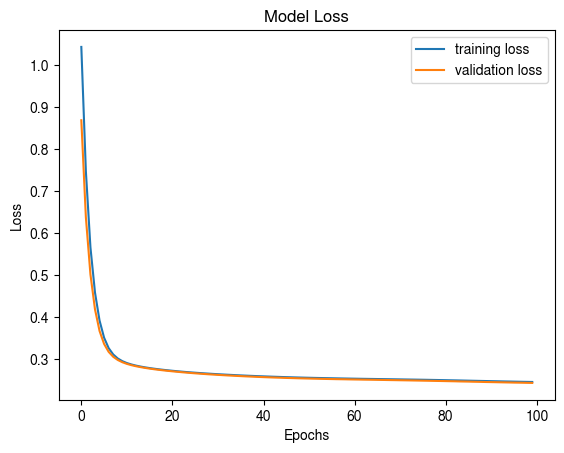

In [31]:
plt.plot(history_model.history["loss"])
plt.plot(history_model.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["training loss","validation loss"], loc="upper right")
plt.savefig("events=406k,layers(100),epochs=20,batch=256,VBF_vs_non_res(m_yy_less5%),trial3.pdf")
#plt.show()

## Testing

In [32]:
# model.load_weights("weights,events=406k,layers(100),epochs=20,VBF_vs_non_res(m_yy_less5%),trial4.hdf5")

In [33]:
d_score = model.predict(x_test,verbose=1)

2168/2168 [==============================] - 1s 488us/step


In [34]:
d_score = d_score.flatten()

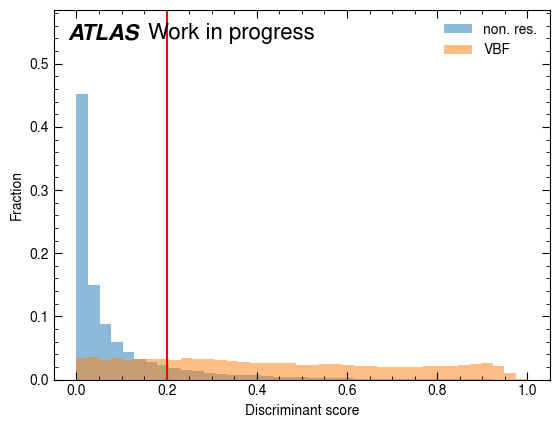

In [35]:
bins = np.linspace(0,1,40)
labels = ["non. res.","VBF"]
for signal in [0,1]:
    mask = y_test == signal
    non_zero = np.count_nonzero(~np.isnan(d_score[mask]))
    weights = np.ones_like(d_score[mask])/float(non_zero)
    plt.hist(d_score[mask],alpha=0.5, label=labels[signal],bins = bins,weights=weights)
    
    
selection = (myy_test[y_test==0]>105e3)&(myy_test[y_test==0]<160e3)
back = myy_test[y_test==0][selection]
sig = myy_test[y_test==1]
sig_cut = d_score[y_test==1][np.argsort(-d_score[y_test==1])][:int(d_score[y_test==1].shape[0]*0.8)]
d_cut = sig_cut[-1]

plt.axvline(x=0.2, color='r', linestyle='-')
plt.xlabel("Discriminant score")
plt.ylabel("Fraction")
plt.ylim([0,0.45])
#plt.yscale("log")
plt.legend(frameon=False)
atlasify("Work in progress")
#plt.savefig("Discriminant score (benchmark).pdf")
#plt.show()

Accuracy:  0.8218389975920292
JSD inclusive=  0.0007229300099425018
JSD higgs region=  0.00023234635591506955


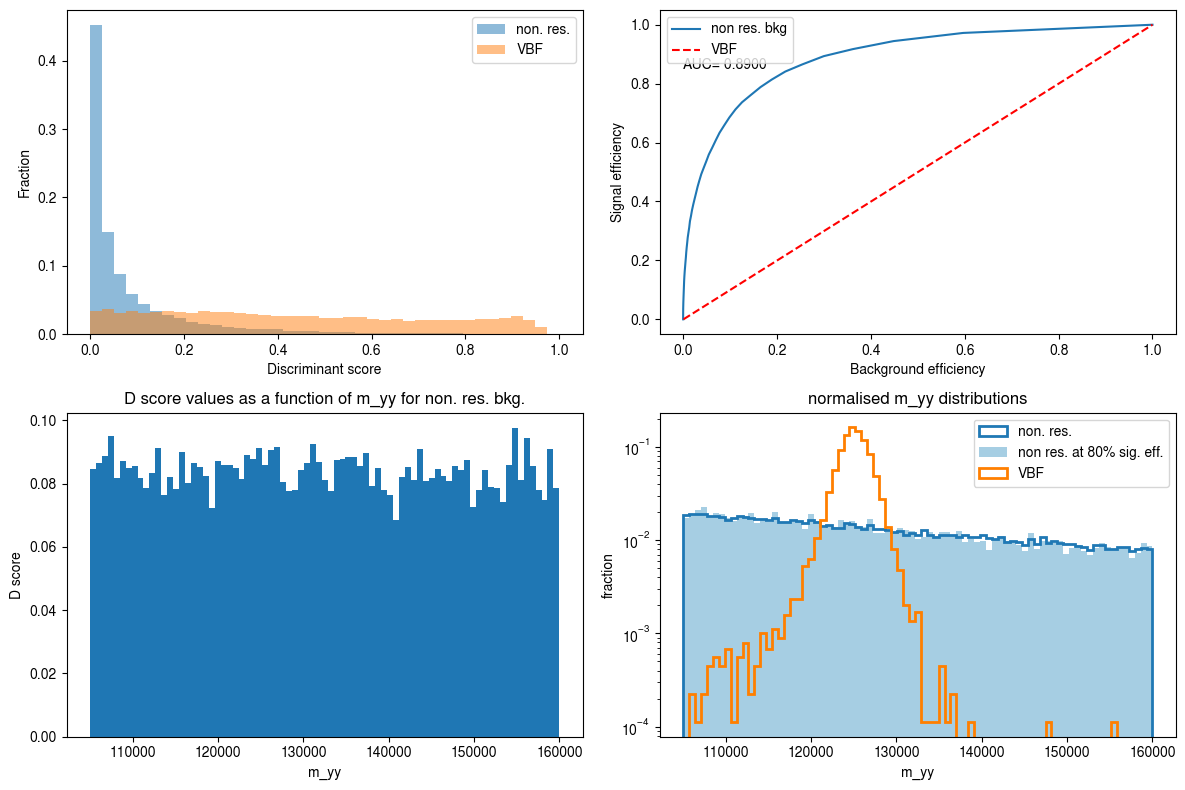

In [39]:
fig, ax = plt.subplots(2,2, figsize=(12,8))
ax = ax.flatten()

plot_dscore(d_score,ax[0])
plot_ROC(d_score,ax[1])
plot_D_score_myy(d_score,ax[2])
plot_sculpting(d_score,0.8,ax[3],"log")
fig.tight_layout()
print("Accuracy: ",accuracy(d_score,0.8))
print("JSD inclusive= ",JSD(d_score,0.8,"incl"))
print("JSD higgs region= ",JSD(d_score,0.8,"higgs"))

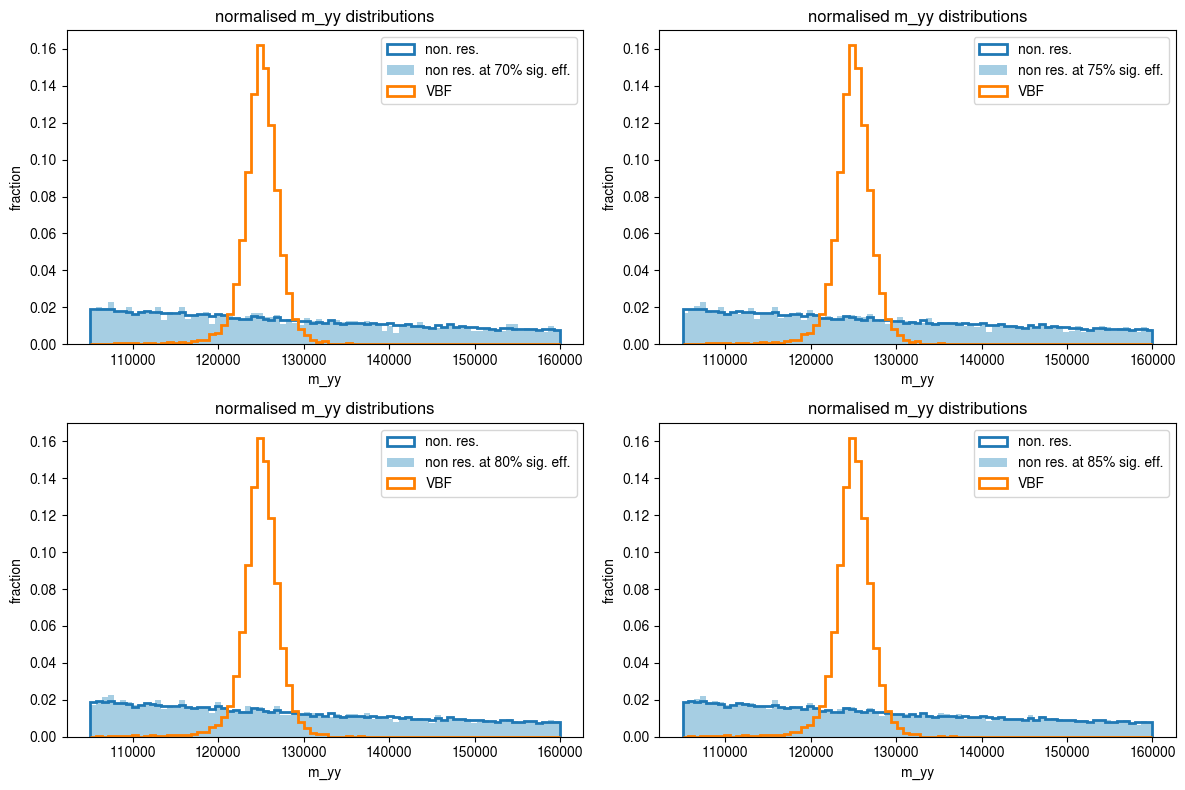

In [40]:
fig, ax = plt.subplots(2,2, figsize=(12,8))
ax = ax.flatten()
plot_sculpting(d_score,0.7,ax[0],"linear")
plot_sculpting(d_score,0.75,ax[1],"linear")
plot_sculpting(d_score,0.8,ax[2],"linear")
plot_sculpting(d_score,0.85,ax[3],"linear")
fig.tight_layout()

### Evaluate sculpting of the benchmark result

Back_eff=  0.17104507804598015


Text(0, 0.5, 'Ratio')

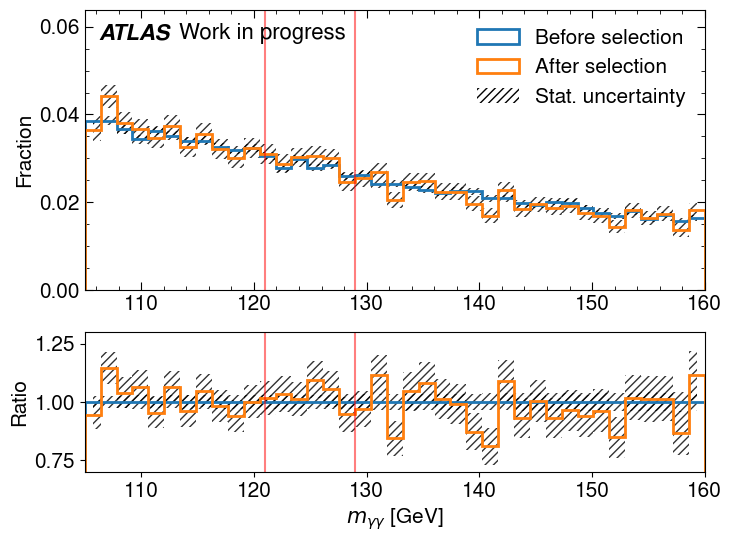

In [41]:
plt.rcParams.update({'font.size': 15})
selection = (myy_test[y_test==0]>105e3)&(myy_test[y_test==0]<160e3)
back = myy_test[y_test==0][selection]
sig = myy_test[y_test==1]
sig_cut = d_score[y_test==1][np.argsort(-d_score[y_test==1])][:int(d_score[y_test==1].shape[0]*0.8)]
d_cut = sig_cut[-1]
back_cut = back[d_score[y_test==0][selection]>d_cut]
back_eff = back_cut.size/back.size
print("Back_eff= ",back_eff)
bins=np.linspace(105e3,160e3,40)/1000
bin_width = (bins[1]-bins[0])
bin_centres = np.linspace(bins[0]+(bin_width/2),bins[-1]-(bin_width/2),39)

dists=[back/1000,back_cut/1000]
labels = ["Before selection","After selection"]
err_label = ["","Stat. uncertainty"]
fractions = []
unscaled_dists = []
weights_comb = []
fig, ax = plt.subplots(2,1,figsize=(8,6), gridspec_kw={'height_ratios': [2, 1]})
for i, values in enumerate(dists):
    non_zero = np.count_nonzero(~np.isnan(values))
    weights = np.ones_like(values)/float(non_zero)
    fraction = ax[0].hist(values, label=labels[i],bins = bins,weights=weights, histtype="step",linewidth=2)
    fractions.append(fraction[0])
    unscaled = np.histogram(values,bins=bins)
    unscaled_dists.append(unscaled[0])
    weights_comb.append(weights[0])
    ax[0].fill_between(bin_centres, fraction[0]-np.sqrt(unscaled[0])*weights[0], fraction[0]+np.sqrt(unscaled[0])*weights[0], 
                       alpha=0.8,step="mid", label=err_label[i],hatch="////",facecolor="none",linewidth=0)
ax[0].legend()
#plt.suptitle("normalised m_yy non_res_bkg distributions before and after D cut at {}% sig. eff.".format(int(100*cut)),y=0.95)
ax[0].axvline(x = 121, color = "red",alpha=0.5)
ax[0].axvline(x = 129, color = "red",alpha=0.5)
atlasify("Work in progress", axes=ax[0])
for i in range(2):
    ax[1].hist(bin_centres,bins=bins,weights=fractions[i]/fractions[0],histtype="step",linewidth=2)
    y_min= (fractions[i]-np.sqrt(unscaled_dists[i])*weights_comb[i])/fractions[0]
    y_max= (fractions[i]+np.sqrt(unscaled_dists[i])*weights_comb[i])/fractions[0]
    ax[1].fill_between(bin_centres, y_min, y_max, 
                           alpha=0.8,step="mid",hatch="////",facecolor="none",linewidth=0)
ax[1].set_ylim(0.7,1.3)
plt.setp(ax, xlim=[105e3/1000,160e3/1000])
ax[1].axvline(x = 121, color = "red",alpha=0.5)
ax[1].axvline(x = 129, color = "red",alpha=0.5)
plt.xlabel("$m_{\gamma \gamma}$ [GeV]")
ax[0].set_ylabel("Fraction")
ax[1].set_ylabel("Ratio")
# plt.savefig("Background ratio plot.png",dpi=300)
# plt.show()

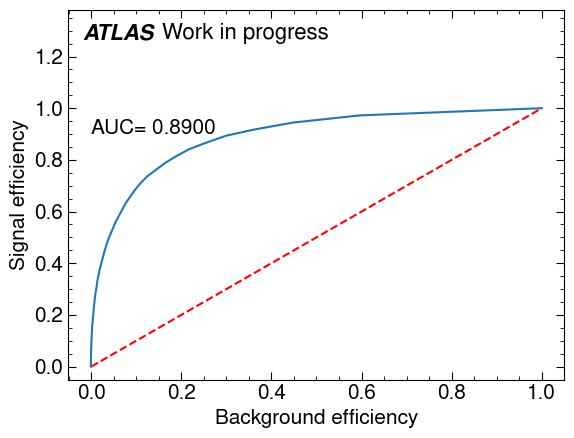

In [42]:
effs=[]
bins = np.linspace(0,1,50)
back = d_score[y_test==0]
sig = d_score[y_test==1]
for dist in [back,sig]:
        # Normalise distributions
        non_zero = np.count_nonzero(~np.isnan(dist))
        weights = np.ones_like(dist)/float(non_zero)
        # Calculate signal and background efficiencies
        frac = np.histogram(dist,bins=bins,weights=weights)[0]
        eff = 1-np.append(0,np.cumsum(frac))
        effs.append(eff)
# Plot ROC curve
plt.plot(effs[0],effs[1])
# Calculate AUC
auc = metrics.auc(effs[0], effs[1])
plt.text(x=0,y=0.9,s="AUC= "+"{:.4f}".format(round(auc, 4)))
plt.plot([0,1], [0,1], linestyle='--', color='red')
plt.xlabel("Background efficiency")
plt.ylabel("Signal efficiency")
atlasify("Work in progress")
#plt.legend(["non res. bkg","VBF","Random classifier"])
plt.show()